In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/train-test2/testing_data2/testing_data2/testing_data/Good/augmented_2319.jpg
/kaggle/input/train-test2/testing_data2/testing_data2/testing_data/Good/augmented_2158.jpg
/kaggle/input/train-test2/testing_data2/testing_data2/testing_data/Good/augmented_2166.jpg
/kaggle/input/train-test2/testing_data2/testing_data2/testing_data/Good/augmented_2215.jpg
/kaggle/input/train-test2/testing_data2/testing_data2/testing_data/Good/augmented_2151.jpg
/kaggle/input/train-test2/testing_data2/testing_data2/testing_data/Good/augmented_2077.jpg
/kaggle/input/train-test2/testing_data2/testing_data2/testing_data/Good/augmented_2231.jpg
/kaggle/input/train-test2/testing_data2/testing_data2/testing_data/Good/augmented_2250.jpg
/kaggle/input/train-test2/testing_data2/testing_data2/testing_data/Good/augmented_2074.jpg
/kaggle/input/train-test2/testing_data2/testing_data2/testing_data/Good/augmented_2307.jpg
/kaggle/input/train-test2/testing_data2/testing_data2/testing_data/Good/augmented_2170.jpg

In [18]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import VGG16
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC, BinaryCrossentropy, FalseNegatives, FalsePositives
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

img_width, img_height = 224, 224
batch_size = 32

# function that takes a model name and applies it
def get_callbacks(model_name):

    # Using Kaggle's working directory and saving the model as .keras
    filepath = os.path.join("/kaggle/working", f'model.{model_name}.keras')

    callbacks = []
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, verbose=1, monitor='val_loss', mode='min')
    
    # naming the model
    callbacks.append(checkpoint)

    anne = ReduceLROnPlateau(factor=0.1, patience=15, verbose=1)
    # if after 15 epochs there is no improvement in val_loss, decrease lr by 90%
    callbacks.append(anne)

    earlystop = EarlyStopping(patience=15, verbose=1, restore_best_weights=True, monitor="val_accuracy")
    # if after 15 epochs there is no improvement, stop
    callbacks.append(earlystop)

    return callbacks

print("ok")

ok


In [19]:
train_path = "/kaggle/input/train-test2/training_data/training_data"
test_path = "/kaggle/input/train-test2/testing_data2/testing_data2/testing_data"
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 5751 images belonging to 2 classes.
Found 639 images belonging to 2 classes.
Found 698 images belonging to 2 classes.


In [20]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [33]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.layers[0].trainable = False  # Freeze VGG16 base layers

In [34]:
print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [35]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

callbacks = get_callbacks('VGG16')

history = model.fit(train_generator, epochs=50,steps_per_epoch=train_generator.samples // train_generator.batch_size, validation_data=validation_generator,validation_steps=validation_generator.samples // validation_generator.batch_size,
callbacks=[callbacks], verbose=1 )

Epoch 1/50
  1/179 ━━━━━━━━━━━━━━━━━━━━ 12:24 4s/step - accuracy: 0.5938 - loss: 0.7023

W0000 00:00:1715970910.165543     193 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/179 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.7221 - loss: 0.8708

W0000 00:00:1715970926.086008     192 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7635 - loss: 0.7126

W0000 00:00:1715970935.385454     195 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: saving model to /kaggle/working/model.VGG16.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 32s 157ms/step - accuracy: 0.7640 - loss: 0.7108 - val_accuracy: 0.9243 - val_loss: 0.2097 - learning_rate: 0.0010
Epoch 2/50
  1/179 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.9688 - loss: 0.1332

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: saving model to /kaggle/working/model.VGG16.keras


W0000 00:00:1715970938.958960     194 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9688 - loss: 0.1332 - val_accuracy: 0.9355 - val_loss: 0.2230 - learning_rate: 0.0010
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9423 - loss: 0.1569
Epoch 3: saving model to /kaggle/working/model.VGG16.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 25s 138ms/step - accuracy: 0.9423 - loss: 0.1568 - val_accuracy: 0.9161 - val_loss: 0.1753 - learning_rate: 0.0010
Epoch 4/50
  1/179 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.9062 - loss: 0.1936
Epoch 4: saving model to /kaggle/working/model.VGG16.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9062 - loss: 0.1936 - val_accuracy: 0.9355 - val_loss: 0.1664 - learning_rate: 0.0010
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9552 - loss: 0.1229
Epoch 5: saving model to /kaggle/working/model.VGG16.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 25s 138ms/step - accuracy: 0.9552 - loss: 0.1229 - val_accuracy: 0.9293 - val_loss: 0.1947 - learning_r

In [36]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print('Test accuracy:', test_acc)

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9997 - loss: 0.0067
Test accuracy: 0.9970238208770752


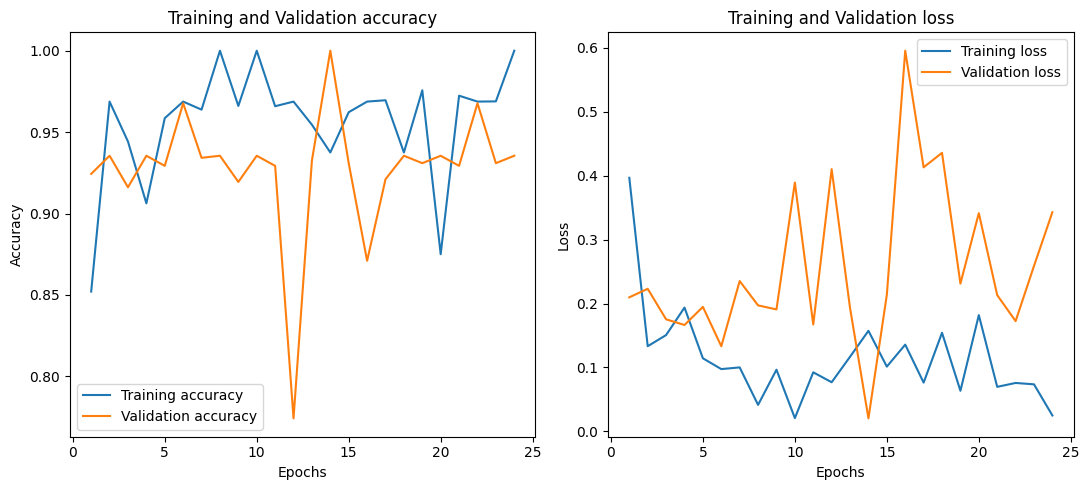

In [37]:
# Plotting

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))

# Train and validation accuracy
ax1.plot(epochs, acc, label='Training accuracy')
ax1.plot(epochs, val_acc, label='Validation accuracy')
ax1.set_title('Training and Validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Train and validation loss
ax2.plot(epochs, loss, label='Training loss')
ax2.plot(epochs, val_loss, label='Validation loss')
ax2.set_title('Training and Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step


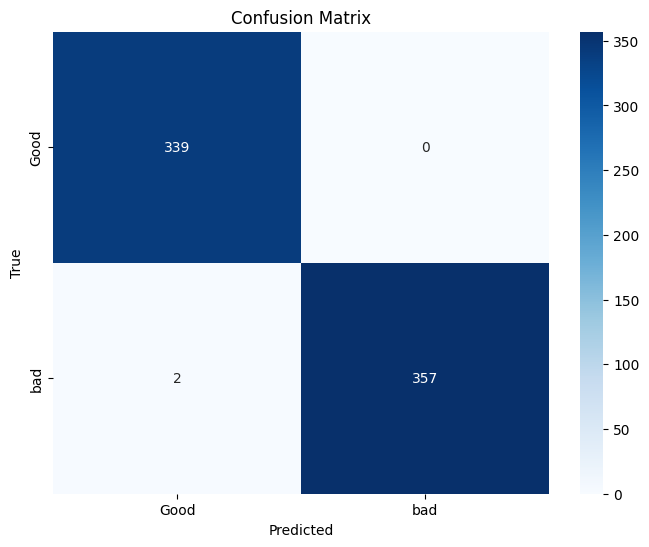

Classification Report:
               precision    recall  f1-score   support

        Good       0.99      1.00      1.00       339
         bad       1.00      0.99      1.00       359

    accuracy                           1.00       698
   macro avg       1.00      1.00      1.00       698
weighted avg       1.00      1.00      1.00       698



In [38]:
import seaborn as sns
y_pred = model.predict(test_generator)
y_pred_classes = np.round(y_pred)

y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Good", "bad"], yticklabels=["Good", "bad"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_true, y_pred_classes, target_names=["Good", "bad"])
print("Classification Report:\n", class_report)

plt.show()